# Week 9-1: Unsupervised Machine Learning

Van Pjotr en Sennen.

Deze week hebben we het over ongesuperviseerde machine learning. Dit is een vorm van machine learning waarbij we geen gelabelde data hebben. Dit betekent dat we geen data hebben waarbij we weten wat de juiste output is. In plaats daarvan gaan we op zoek naar patronen in de data. Dit kan bijvoorbeeld zijn dat we clusters van data vinden, of dat we de data kunnen reduceren naar een kleinere dimensie.

Maar deze keer gaan we clustering gebruiken, een techniek waarbij we data in groepen verdelen. Dit kan bijvoorbeeld handig zijn als we een dataset hebben met verschillende soorten bloemen, en we willen weten welke bloemen bij elkaar horen. Of als we een dataset hebben met verschillende soorten klanten, en we willen weten welke klanten bij elkaar horen.

PR9-1: Great Outdoors wil graag weten in welke segmenten verkoopafdelingen (‘sales_branches’) opgedeeld kan worden. Er bestaan al retailersegmenten (table ‘retailer_segment’), Great Outdoors wil dus óók segmenten creëren voor verkoopafdelingen:
- Pas waar nodig Dummy Encoding toe.
- Train het initiële clustermodel.
- Experimenteer met meerdere k’s door het berekenen van de inter- en intraclusterafstand.

Maar eerst een voorbeeld met de titanic.

## Bibliotheken importeren

In [43]:
import pandas as pd
import sqlite3
from sklearn.cluster import KMeans
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.simplefilter('ignore')

## Data inlezen en kolommen selecteren

In [44]:
df = pd.read_csv("data/titanic2.csv", sep = ';')
df = df.filter(regex='^(?!Unnamed).*$')
df

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Age
0,1,3,Braund; Mr. Owen Harris,male,1,0,A/5 21171,7.25,NaN,S,0,22
1,2,1,Cumings; Mrs. John Bradley (Florence Briggs Th...,female,1,0,PC 17599,712.833,C85,C,1,38
2,3,3,Heikkinen; Miss. Laina,female,0,0,STON/O2. 3101282,7.925,NaN,S,1,26
3,4,1,Futrelle; Mrs. Jacques Heath (Lily May Peel),female,1,0,113803,53.1,C123,S,1,35
4,5,3,Allen; Mr. William Henry,male,0,0,373450,8.05,NaN,S,0,35
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,Montvila; Rev. Juozas,male,0,0,211536,13,NaN,S,0,27
887,888,1,Graham; Miss. Margaret Edith,female,0,0,112053,30,B42,S,1,19
888,889,3,"Johnston; Miss. Catherine Helen ""Carrie""",female,1,2,W./C. 6607,23.45,NaN,S,0,15
889,890,1,Behr; Mr. Karl Howell,male,0,0,111369,30,C148,C,1,26


In [45]:
df = df.loc[:, ['Pclass', 'Sex', 'Age', 'Survived']]
df

,Pclass,Sex,Age,Survived
0,3,male,22,0
1,1,female,38,1
2,3,female,26,1
3,1,female,35,1
4,3,male,35,0
...,...,...,...,...
886,2,male,27,0
887,1,female,19,1
888,3,female,15,0
889,1,male,26,1


## One-hot encoding van onafhankelijke niet-numerieke variabelen

In [46]:
df['Pclass'] = df['Pclass'].astype(str)
df.dtypes

Pclass      object
Sex         object
Age          int64
Survived     int64
dtype: object

In [47]:
dummies_dataframe = pd.get_dummies(df.loc[:, ['Sex', 'Pclass']])
dummies_dataframe

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,False,True,False,False,True
1,True,False,True,False,False
2,True,False,False,False,True
3,True,False,True,False,False
4,False,True,False,False,True
...,...,...,...,...,...
886,False,True,False,True,False
887,True,False,True,False,False
888,True,False,False,False,True
889,False,True,True,False,False


In [48]:
df = pd.concat([df, dummies_dataframe], axis = 1)
df = df.drop(['Sex'], axis = 1)
df = df.loc[:, ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'Age', 'Survived']]
df

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Survived
0,False,False,True,False,True,22,0
1,True,False,False,True,False,38,1
2,False,False,True,True,False,26,1
3,True,False,False,True,False,35,1
4,False,False,True,False,True,35,0
...,...,...,...,...,...,...,...
886,False,True,False,False,True,27,0
887,True,False,False,True,False,19,1
888,False,False,True,True,False,15,0
889,True,False,False,False,True,26,1


## Clusteringmodel bouwen met 2 dimensies

In [49]:
df_2d = df.loc[:, ['Age', 'Survived']]
df_2d

,Age,Survived
0,22,0
1,38,1
2,26,1
3,35,1
4,35,0
...,...,...
886,27,0
887,19,1
888,15,0
889,26,1


In [50]:
kmeans = KMeans(n_clusters = 3, random_state = 42)
kmeans.fit_predict(df_2d)

array([0, 2, 2, 2, 2, 2, 1, 0, 2, 0, 0, 1, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2,
       0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 0, 0, 1, 2, 1, 2, 0, 2, 0, 0, 0, 2, 1, 0, 2, 2,
       2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 2,
       0, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2,
       1, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 2, 2, 1, 2, 0,
       1, 2, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 1, 2,
       0, 1, 0, 2, 0, 0, 1, 2, 2, 0, 0, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 0,
       0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 1, 1, 0, 2,
       0, 2, 2, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 0, 2, 2, 1, 0, 0, 2, 2, 2,
       2, 0, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2,
       2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 1, 2, 0, 0, 2, 2,
       2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 1, 1, 1,

In [51]:
kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

,0,1
0,15.992481,0.379699
1,54.156682,0.354839
2,31.632353,0.401961


In [52]:
for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df_2d.columns[i]}'})
    
kmeans_centra

,Age,Survived
0,15.992481,0.379699
1,54.156682,0.354839
2,31.632353,0.401961


In [53]:
for src_index, _ in df_2d.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df_2d.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df_2d.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df_2d.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df_2d

Afstand van bronindex 0 tot...
	Centrumindex 0:
		22 - 15.992481203007529 = 6.007518796992471
		0 - 0.3796992481203007 = -0.3796992481203007
	Totale euclidische som: 36.234453615240994
	Euclidische afstand: 6.0195060939616125
------------------------------------------------
	Centrumindex 1:
		22 - 54.156682027649765 = -32.156682027649765
		0 - 0.3548387096774193 = -0.3548387096774193
	Totale euclidische som: 1034.178109537259
	Euclidische afstand: 32.15863973393867
------------------------------------------------
	Centrumindex 2:
		22 - 31.63235294117647 = -9.632352941176471
		0 - 0.4019607843137254 = -0.4019607843137254
	Totale euclidische som: 92.94379565551712
	Euclidische afstand: 9.640736261070371
------------------------------------------------
{0: 6.0195060939616125, 1: 32.15863973393867, 2: 9.640736261070371}
0
Afstand van bronindex 1 tot...
	Centrumindex 0:
		38 - 15.992481203007529 = 22.00751879699247
		1 - 0.3796992481203007 = 0.6203007518796992
	Totale euclidische som: 484.

,Age,Survived,Centrum
0,22,0,0.0
1,38,1,2.0
2,26,1,2.0
3,35,1,2.0
4,35,0,2.0
...,...,...,...
886,27,0,2.0
887,19,1,0.0
888,15,0,0.0
889,26,1,2.0


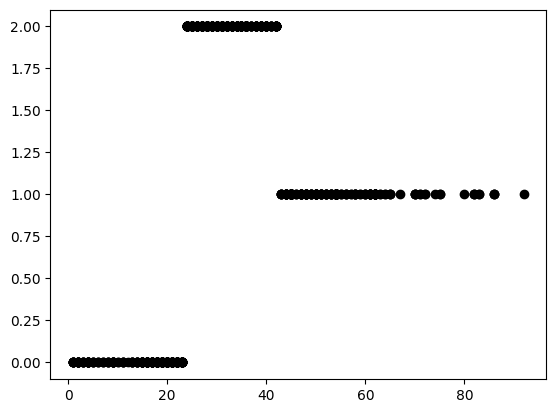

In [54]:
plt.scatter(df_2d['Age'], df_2d['Centrum'], color = 'k')
plt.show()

In [55]:
df_2d.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,266
1,217
2,408


## Clusteringmodel bouwen met meer dan 2 dimensies (alle kolommen uit de dataset)

### Centra berekenen

In [56]:
kmeans = KMeans(n_clusters = 6, random_state = 42)
prediction_results = kmeans.fit_predict(df)
prediction_results

array([0, 1, 2, 2, 2, 2, 5, 4, 2, 0, 4, 5, 0, 1, 0, 5, 4, 2, 2, 2, 2, 2,
       0, 2, 4, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 4, 0, 1, 2, 5, 2, 0, 2, 4, 4, 0, 1, 1, 4, 1, 1,
       2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 1, 1, 3, 2, 0, 2, 0, 2, 0, 2, 0, 0,
       0, 0, 2, 0, 1, 2, 5, 0, 3, 0, 2, 2, 2, 0, 0, 2, 2, 2, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 3, 2, 0, 4, 0, 3, 2, 2, 5, 4, 2, 0, 2, 1, 2, 0,
       1, 2, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 2, 4, 2, 1, 5, 0, 5, 1,
       0, 5, 0, 2, 0, 0, 1, 1, 2, 0, 4, 4, 0, 1, 0, 2, 5, 4, 4, 0, 5, 0,
       0, 5, 2, 2, 0, 0, 4, 4, 4, 0, 0, 1, 1, 2, 2, 0, 0, 4, 1, 5, 0, 1,
       0, 0, 2, 0, 2, 1, 0, 4, 2, 2, 0, 1, 0, 2, 0, 2, 1, 2, 2, 1, 2, 2,
       0, 2, 5, 1, 1, 0, 0, 0, 0, 2, 2, 2, 5, 4, 0, 2, 1, 4, 0, 2, 2, 2,
       2, 0, 2, 1, 0, 0, 2, 5, 2, 2, 5, 2, 1, 2, 2, 2, 2, 5, 2, 4, 5, 1,
       2, 2, 0, 0, 5, 2, 2, 0, 1, 2, 2, 5, 1, 2, 4, 2, 5, 2, 0, 0, 2, 2,
       2, 0, 1, 0, 2, 0, 2, 0, 0, 2, 0, 4, 5, 5, 5,

In [57]:
df['Centrum'] = prediction_results
df

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Age,Survived,Centrum
0,False,False,True,False,True,22,0,0
1,True,False,False,True,False,38,1,1
2,False,False,True,True,False,26,1,2
3,True,False,False,True,False,35,1,2
4,False,False,True,False,True,35,0,2
...,...,...,...,...,...,...,...,...
886,False,True,False,False,True,27,0,2
887,True,False,False,True,False,19,1,0
888,False,False,True,True,False,15,0,0
889,True,False,False,False,True,26,1,2


### De juiste centra toewijzen aan rijen uit de dataset

In [58]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,265
1,145
2,285
3,22
4,61
5,113


# De Sales Branches clusteren

Om de segmenten van de verkoopafdelingen te bepalen, gaan we de volgende stappen doorlopen:
- We kunnen de segmenten op basis van producten categorieën en het verkoop van die producten, bepalen welke segmenten we nodig zullen hebben voor onze verkoopafdeling.
- We pakken daarbij ook de branches van de retailers erbij, zodat we de segmenten van de verkoopafdelingen kunnen bepalen.
- Daarna zullen we gebaseerd op de omzet en kosten van de verkoopafdelingen, de segmenten bepalen.
- Waar we dan de gemixte data in een clustering model zullen stoppen en de segmenten bepalen.

Eerst gaan we de data inladen.

In [59]:
# Verbinding maken met de databases
conn_sales = sqlite3.connect('data/go_sales.sqlite')
conn_crm = sqlite3.connect('data/go_crm.sqlite')
conn_staff = sqlite3.connect('data/go_staff.sqlite')

# Gegevens ophalen uit de databases (Helaas verouderd)
sales_branch = pd.read_sql_query("SELECT * FROM sales_branch", conn_staff)
# country1 = pd.read_sql_query("SELECT * FROM country", conn_sales)
# country2 = pd.read_sql_query("SELECT * FROM country", conn_crm)
# territory = pd.read_sql_query("SELECT * FROM sales_territory", conn_crm)

orders_header = pd.read_sql_query("SELECT * FROM order_header;", conn_sales)
order_details = pd.read_sql_query("SELECT * FROM order_details;", conn_sales)

Hier gaan we de data van de great outdoors inlezen en bepaalde data dropen.

In [60]:
# (Helaas Verouderd)
# country = country1[['CURRENCY_NAME', 'LANGUAGE']]
# country = pd.concat([country2, country], axis = 1)
# sales_branch.drop('TRIAL633', axis=1, inplace=True)
# country.drop('TRIAL219', axis=1, inplace=True)
# territory.drop('TRIAL222', axis=1, inplace=True)
orders_header.drop('TRIAL885', axis=1, inplace=True)
order_details.drop('TRIAL879', axis=1, inplace=True)
sales_branch.drop('TRIAL633', axis=1, inplace=True)
sales_branch.drop(["ADDRESS1", "ADDRESS2", "POSTAL_ZONE"], axis=1)

,SALES_BRANCH_CODE,CITY,REGION,COUNTRY_CODE
0,13,Hamburg,None,2
1,14,München,None,2
2,15,Kista,None,10
3,17,Calgary,Alberta,4
4,18,Toronto,Ontario,4
5,19,Boston,Massachusetts,3
6,20,Seattle,Washington,3
7,21,Los Angeles,California,3
8,22,Miami,Florida,3
9,23,Lyon,None,1


Nu gaan we data mergen. Orders worden samengevoegd met details om een compleet beeld van de bestellingen te krijgen.

Productinformatie wordt geladen en samengevoegd om een lookup-tabel te maken voor productnummers naar productcategorieën.

Verkoopgegevens worden voorbereid, zoals de omzet- en afzetgegevens per verkoopfiliaal en de verhouding van de verkoop per productlijn.

Bij de productlijn wordt ook dummy encoding toegepast.

We zullen later de branches dummies geven.

In [61]:
order_full = pd.merge(order_details, orders_header, on='ORDER_NUMBER')
order_full['UNIT_SALE_PRICE'] = order_full['UNIT_SALE_PRICE'].astype(float)
order_full['UNIT_PRICE'] = order_full['UNIT_PRICE'].astype(float)
order_full['UNIT_COST'] = order_full['UNIT_COST'].astype(float)

# Lees productstabellen
product = pd.read_sql_query("SELECT * FROM product;", conn_sales)
product_type = pd.read_sql_query("SELECT * FROM product_type;", conn_sales)
product_line = pd.read_sql_query("SELECT * FROM product_line;", conn_sales)

# Maak lookuptabel voor productnumber -> naam productscategorie
product_line_lookup = pd.merge(product, product_type, on='PRODUCT_TYPE_CODE')
product_line_lookup = pd.merge(product_line_lookup, product_line, on='PRODUCT_LINE_CODE')
product_line_lookup = product_line_lookup.loc[:,['PRODUCT_NUMBER', 'PRODUCT_LINE_EN']]

# Maak dummies van product_line
product_line_dummies = pd.get_dummies(product_line_lookup['PRODUCT_LINE_EN'])

product_line_lookup = product_line_lookup.drop(['PRODUCT_LINE_EN'], axis=1)
product_line_lookup = pd.concat([product_line_dummies, product_line_lookup], axis = 1)

# Omzet/Afzetsdata
sales_profit_data = order_full.groupby('SALES_BRANCH_CODE').aggregate('sum') #.reset_index()
sales_profit_data = sales_profit_data[['QUANTITY', 'UNIT_COST', 'UNIT_PRICE', 'UNIT_SALE_PRICE']]

# Productsverkoopdata (Verhouding van verkoop per productlijn)
sales_product_data = pd.merge(order_full, product_line_lookup, on='PRODUCT_NUMBER')
sales_product_data = sales_product_data[['SALES_BRANCH_CODE', 'Camping Equipment', 'Golf Equipment', 'Mountaineering Equipment', 'Outdoor Protection' , 'Personal Accessories']]
sales_product_data = sales_product_data.groupby('SALES_BRANCH_CODE').aggregate(np.mean)

## Clusteringmodel bouwen met 2 dimensies

Eerst wordt een 2D-dataset gemaakt met hoeveelheid en eenheidsprijs van de verkochte producten.

Waar we ook dummy encoding toepassen.

In [62]:
table = sales_profit_data[['QUANTITY', 'UNIT_SALE_PRICE']]
df = pd.get_dummies(table)  # Dummy encoding

table = pd.concat([table, df], axis=1)
table

,QUANTITY,UNIT_SALE_PRICE,QUANTITY,UNIT_SALE_PRICE
SALES_BRANCH_CODE,,,,
13,102648,188463.46,102648,188463.46
14,116778,206523.20,116778,206523.20
15,158062,517067.65,158062,517067.65
17,73848,88668.11,73848,88668.11
18,171852,324804.56,171852,324804.56
19,88444,321688.92,88444,321688.92
20,76848,342898.94,76848,342898.94
21,83110,403109.89,83110,403109.89
22,33550,168475.23,33550,168475.23


Een k-means clusteringmodel wordt geïnstantieerd met het gewenste aantal clusters (3 of 4 in het eerste geval, met een willenkeurigheid van 42) en toegepast op de 2D-dataset.

In [63]:
# Train het clustermodel
kmeans = KMeans(n_clusters=4, random_state=42)
prediction_results = kmeans.fit_predict(df)
prediction_results

kmeans_centra = pd.DataFrame(kmeans.cluster_centers_)
kmeans_centra

for i in range(len(kmeans_centra.columns)):
    kmeans_centra = kmeans_centra.rename(columns = {i : f'{df.columns[i]}'})
    
kmeans_centra

,QUANTITY,UNIT_SALE_PRICE
0,84293.250000,224765.831250
1,117837.714286,378810.968571
2,51601.000000,112020.036667
3,58076.857143,177952.921429


De centra van de clusters worden geëxtraheerd en weergegeven.
Voor elk punt in de dataset wordt de afstand tot elk clustercentrum berekend, en het punt wordt toegewezen aan het dichtstbijzijnde cluster.


In [64]:
for src_index, _ in df.iterrows():
    euclidian_distances = dict()
    print(f"Afstand van bronindex {src_index} tot...")

    for centrumindex, _ in kmeans_centra.iterrows():
        print(f"\tCentrumindex {centrumindex}:")
        euclidian_sum = 0

        for column_name in kmeans_centra.columns:
            current_difference = df.at[src_index, column_name] - kmeans_centra.at[centrumindex, column_name]
            print(f'\t\t{df.at[src_index, column_name]} - {kmeans_centra.at[centrumindex, column_name]} = {current_difference}')
            euclidian_sum += current_difference ** 2
        
        print(f'\tTotale euclidische som: {euclidian_sum}')
        euclidian_distance = math.sqrt(euclidian_sum)
        print(f'\tEuclidische afstand: {euclidian_distance}')
        euclidian_distances[centrumindex] = euclidian_distance
        print('------------------------------------------------')
    
    print(euclidian_distances)
    centrum_number = min(euclidian_distances, key = euclidian_distances.get)
    print(centrum_number)
    df.at[src_index, 'Centrum'] = centrum_number
    print("================================================")

df

Afstand van bronindex 13 tot...
	Centrumindex 0:
		102648 - 84293.25 = 18354.75
		188463.46 - 224765.83125 = -36302.37125
	Totale euclidische som: 1654759005.9353263
	Euclidische afstand: 40678.729158312286
------------------------------------------------
	Centrumindex 1:
		102648 - 117837.71428571429 = -15189.71428571429
		188463.46 - 378810.96857142856 = -190347.50857142857
	Totale euclidische som: 36462901439.43171
	Euclidische afstand: 190952.61569151576
------------------------------------------------
	Centrumindex 2:
		102648 - 51601.0 = 51047.0
		188463.46 - 112020.03666666668 = 76443.42333333331
	Totale euclidische som: 8449393179.919208
	Euclidische afstand: 91920.58082888297
------------------------------------------------
	Centrumindex 3:
		102648 - 58076.857142857145 = 44571.142857142855
		188463.46 - 177952.92142857146 = 10510.538571428537
	Totale euclidische som: 2097058196.6533234
	Euclidische afstand: 45793.6479945999
------------------------------------------------
{0:

,QUANTITY,UNIT_SALE_PRICE,Centrum
SALES_BRANCH_CODE,,,
13,102648,188463.46,0.0
14,116778,206523.20,0.0
15,158062,517067.65,1.0
17,73848,88668.11,2.0
18,171852,324804.56,1.0
19,88444,321688.92,1.0
20,76848,342898.94,1.0
21,83110,403109.89,1.0
22,33550,168475.23,3.0


De resultaten worden gevisualiseerd door een scatterplot te maken van de kwantiteit versus de eenheidsprijs, waarbij de punten zijn gekleurd op basis van hun toegewezen cluster.

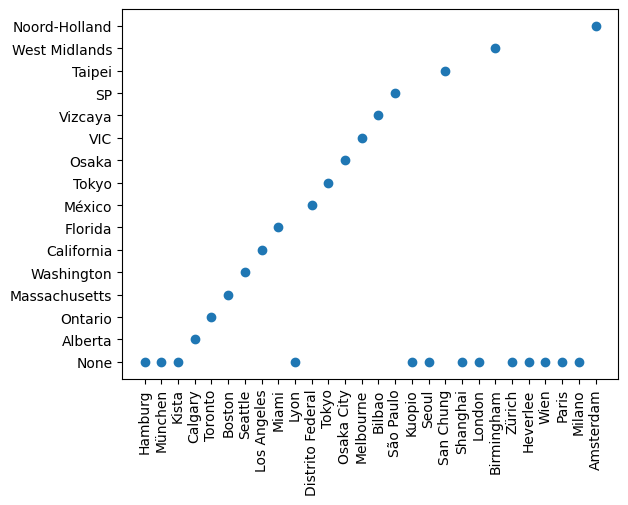

In [83]:
# (Helaas verouderd)
# plt.scatter(table['TERRITORY_NAME_EN'], table['CURRENCY_NAME'], c = prediction_results, cmap = 'rainbow')
# plt.show()
# Nu gaan we een bar weergeven, waar alle quantiteiten worden weergegeven per sales_branch
# Create a DataFrame with the branch names mapping
branch_names = sales_branch[['SALES_BRANCH_CODE', 'CITY', 'REGION']]
branch_names = branch_names.drop_duplicates()
branch_names['CITY']

plt.scatter(branch_names['CITY'].astype(str), branch_names['REGION'].astype(str))
plt.xticks(rotation=90)
plt.show()

De centra van de clusters worden geëxtraheerd en weergegeven.

In [86]:
df.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,8
1,7
2,6
3,7


## Clusteringmodel bouwen met meer dan 2 dimensies (alle kolommen uit de dataset)

Nu gaan we hetzelfde doen als hierboven, maar dan met alle kolommen uit de dataset. En misschien ook verder testen met verschillende k's.

In [87]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
prediction_results = kmeans.fit_predict(sales_product_data)
prediction_results

array([4, 4, 2, 2, 4, 3, 2, 3, 4, 4, 0, 1, 1, 2, 0, 3, 2, 1, 1, 1, 3, 3,
       2, 2, 2, 4, 2, 4])

In [88]:
sales_product_data['Centrum'] = prediction_results
sales_product_data

,Camping Equipment,Golf Equipment,Mountaineering Equipment,Outdoor Protection,Personal Accessories,Centrum
SALES_BRANCH_CODE,,,,,,
13,0.409370,0.123656,0.132873,0.133641,0.200461,4
14,0.377478,0.155432,0.161776,0.096749,0.208565,4
15,0.411430,0.085079,0.213085,0.119214,0.171192,2
17,0.383126,0.042877,0.237898,0.106501,0.229599,2
18,0.401382,0.178628,0.106326,0.117491,0.196172,4
19,0.532534,0.084760,0.048373,0.140839,0.193493,3
20,0.391703,0.076419,0.253712,0.086463,0.191703,2
21,0.468878,0.087633,0.142097,0.112203,0.189189,3
22,0.405076,0.165482,0.081218,0.148223,0.200000,4


In [89]:
sales_product_data.groupby('Centrum', as_index = False)['Centrum'].count()

,Centrum
0,2
1,5
2,9
3,5
4,7


Hier visualiseren we de gemiddelde verkoop van verschillende productcategorieën binnen elk cluster.

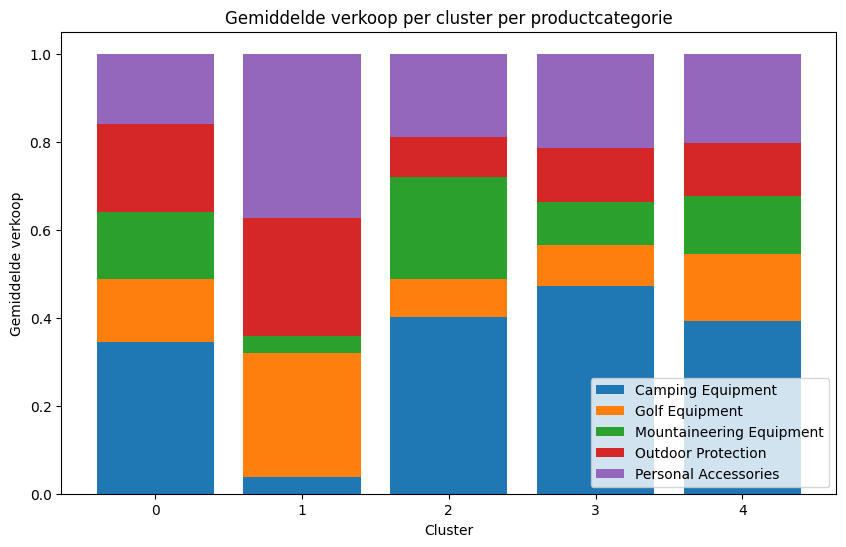

In [90]:
cluster_sales_mean = sales_product_data.groupby('Centrum').mean()

# Visualisatie van gemiddelde verkoop per cluster
plt.figure(figsize=(10, 6))
plt.bar(cluster_sales_mean.index, cluster_sales_mean['Camping Equipment'], label='Camping Equipment')
plt.bar(cluster_sales_mean.index, cluster_sales_mean['Golf Equipment'], bottom=cluster_sales_mean['Camping Equipment'], label='Golf Equipment')
plt.bar(cluster_sales_mean.index, cluster_sales_mean['Mountaineering Equipment'], bottom=cluster_sales_mean['Camping Equipment']+cluster_sales_mean['Golf Equipment'], label='Mountaineering Equipment')
plt.bar(cluster_sales_mean.index, cluster_sales_mean['Outdoor Protection'], bottom=cluster_sales_mean['Camping Equipment']+cluster_sales_mean['Golf Equipment']+cluster_sales_mean['Mountaineering Equipment'], label='Outdoor Protection')
plt.bar(cluster_sales_mean.index, cluster_sales_mean['Personal Accessories'], bottom=cluster_sales_mean['Camping Equipment']+cluster_sales_mean['Golf Equipment']+cluster_sales_mean['Mountaineering Equipment']+cluster_sales_mean['Outdoor Protection'], label='Personal Accessories')
plt.xlabel('Cluster')
plt.ylabel('Gemiddelde verkoop')
plt.title('Gemiddelde verkoop per cluster per productcategorie')
plt.legend()
plt.show()

## Evaluatie van de clustering

Hier gaan we de inter- en intraclusterafstand berekenen voor verschillende k's.

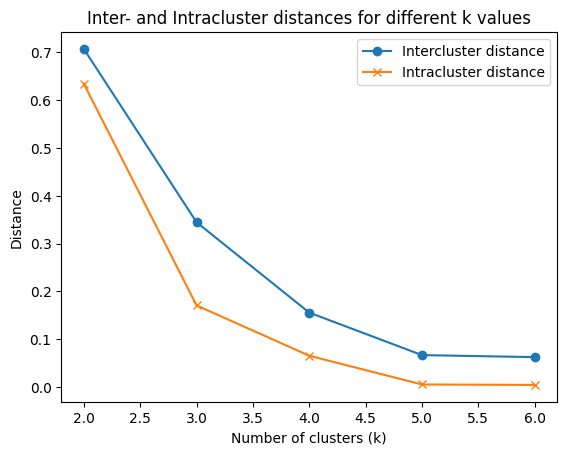

In [91]:
# Lijst om interclusterafstanden op te slaan
intercluster_distances = []

# Lijst om intraclusterafstanden op te slaan
intracluster_distances = []

# Lijst van verschillende k's om te evalueren
k_values = [2, 3, 4, 5, 6]

for k in k_values:
    # K-means clusteringmodel toepassen
    kmeans = KMeans(n_clusters=k, random_state=42)
    prediction_results = kmeans.fit_predict(sales_product_data)
    
    # Interclusterafstand
    intercluster_distance = np.sum(np.min(kmeans.transform(sales_product_data), axis=1)) / sales_product_data.shape[0]
    intercluster_distances.append(intercluster_distance)
    
    # Intraclusterafstand
    intracluster_distance = kmeans.inertia_ / sales_product_data.shape[0]
    intracluster_distances.append(intracluster_distance)

# Visualisatie van inter- en intraclusterafstanden voor verschillende k's
plt.plot(k_values, intercluster_distances, marker='o', label='Intercluster distance')
plt.plot(k_values, intracluster_distances, marker='x', label='Intracluster distance')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distance')
plt.title('Inter- and Intracluster distances for different k values')
plt.legend()
plt.show()